## Task 2: Generate positive and negative instances for training the classifiers
-----------------------------------------------------------------------------------
Author: Rajesh Siraskar
Created: 07-Dec-2018
- 08-Dec-2018: Read annotation file and ability to understand bounding boxes
- 11-Dec-2018: Patch up background with adjacent 'filler' image
- 13-Dec-2018: Understand pedestrian dimensions via histogram - for best scaling options
- 14-Dec-2018: Data augmentation. 2 modes added - reflection and Gaussian blur
- 15-Dec-2018: Create negative instances from patched background
- 31-Dec-2018: Add histogram normalization for images to improve detection? 
-               Testing has indicated that background is being picked up as pedestrians
- 07-Jan-2019: From learnings based on testing HoG using a Bilateral filter with a heavy sigma- A pre-processing is applied to   -                create positive instances with this filtering. Add a sigma=80 and 160 augmented images
- 12-Jan-2019: To improve recall added custom background - based on study of the false-positives

**Folders**:
    1. train-210 and train-400: 610 images for training. To be expanded to 5,000
    3. tud-pedestrians: 250 test images

In [1]:
# Jupyter specific command to plot images inline with document
%matplotlib inline

# Import modules
import cv2
import numpy as np
import pandas as pd
import random
import csv
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

In [2]:
## Top level parameters
path = 'images/'

# Parameters: Source for original images to be processed into training instances
path_training_images = path + 'train-610/'
annotation_file = path_training_images + 'train-610.idl'

# Add a super suffix for identification
#   E.g.: 'S1' for source 1, 'S2' for source 2 etc.
training_instance_suffix = 'T610'

SHOW_PLOT = False

### Function: ProcessAnnotationFile

In [71]:
## Function to process annotation file

def ProcessAnnotationFile(annotation_file):

    print('- Processing annotation file ', annotation_file)
    
    # Initiatlize an empty data frame
    columns = ['ImageFile','BoundingBoxes']
    df_images = pd.DataFrame(columns=columns)    
   
    with open(annotation_file) as file_handle:
        csv_reader = csv.reader(file_handle, delimiter=";")
        for n, line in enumerate(csv_reader):            
            
            flag_multiple_pedestrians = False
            line_elements = [line[p].replace(':-1', '') for p in range(len(line))]
            
            line_elements = line_elements[0].split(':')
            
            # Separate the image file name from the pedestrian bounding boxes
            image_file_name = line_elements[0]
            bounding_box_list = line_elements[1]
            
            # Store elements into the data frame
            df_images.loc[n] = [image_file_name, bounding_box_list]
            
            numeric_bounding_boxes = ProcessPedestrianBoundingBoxes(bounding_box_list)
            numeric_bounding_boxes = np.asarray(numeric_bounding_boxes)
            
    print('- Done. Annotations for {:04d} images was processed'.format(n))
    # Return the assembed data frame of image file name and annotations
    return (df_images)

In [72]:
def ProcessPedestrianBoundingBoxes(bounding_box_list):
    
    # Clean the list
    bounding_box_list = bounding_box_list.replace('),', ';').replace(')', ';').replace('(','').replace(' ','')
    bounding_box_list = bounding_box_list.split(';')
    
    # Remove the last empty item
    bounding_box_list.pop()
    bounding_box_list
    
    n_pedestriants = len(bounding_box_list)

    if (n_pedestriants > 1): 
        list_bounding_box = [list(map(int, bounding_box_list[n].split(','))) 
                                  for n in range(n_pedestriants)]
    else:
        list_bounding_box = list(map(int, bounding_box_list[0].split(',')))
        
    return(list_bounding_box)

In [73]:
df_training = ProcessAnnotationFile(annotation_file)

- Processing annotation file  images/train-610/train-610.idl
- Done. Annotations for 0609 images was processed


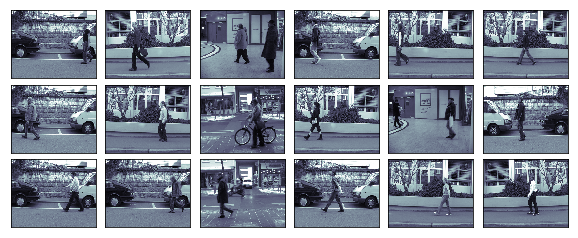

In [74]:
# Test import by showing first few images 
fig, axes = plt.subplots(3, 6, figsize=(10, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    imagefile = random.choice(list(df_training.ImageFile))
    image = cv2.imread(path_training_images+imagefile, cv2.IMREAD_GRAYSCALE) 
    ax.imshow(image, cmap='bone')

### Extraction of ROIs

Extract ROI i.e. predestrian and store as a positive training image and background as a negative instance

The sample images have the bounding box annotation in the format [xmin, ymin, xmax, ymax]

    Bounding rectangle mapped to annotated  file coordinates:
        x1 = num_coordinates[0], y1 = num_coordinates[1]
        x2 = num_coordinates[2], y2 = num_coordinates[3]

To access parts of image array (e.g. pedestrians) we need to use array indexing i.e. rows then cols:

        ROI = image (y1:y2, x1:x2)

## Define a function to perform this extraction

The function will take an image as parameter and performs the extractions and annotated list of coordinates

In [75]:
def ConvertToArrayIndices (bounding_box):
    # Pedestrian bounding co-ordinatess
    pedestrian_x1 = bounding_box[0]
    pedestrian_y1 = bounding_box[1]
    pedestrian_x2 = bounding_box[2]
    pedestrian_y2 = bounding_box[3]

    # Check if the bounding box is 'impossible' i.e. y1 and y2 swapped (similarly for x's)
    #  In case they are, then swap y1 and y2 (similarly for x's)
    if (pedestrian_y1 > pedestrian_y2): 
        temp = pedestrian_y1
        pedestrian_y1 = pedestrian_y2
        pedestrian_y2 = temp

    if (pedestrian_x1 > pedestrian_x2): 
        temp = pedestrian_x1
        pedestrian_x1 = pedestrian_x2
        pedestrian_x2 = temp
    
    return (pedestrian_x1, pedestrian_x2, pedestrian_y1, pedestrian_y2)

In [76]:
def CreatePositiveInstance (image, pedestrian_x1, pedestrian_x2, pedestrian_y1, pedestrian_y2):    
    pedestrian_image = image[pedestrian_y1:pedestrian_y2, pedestrian_x1:pedestrian_x2].copy() 
    
    # 31-Dec-2018: Improve contrast by histogram equalization
    pedestrian_image = cv2.equalizeHist(pedestrian_image)

    return (pedestrian_image)

### Fill void left by extracting pedestrian

- Pick a region to the right or left of pedestrian to fill void
- Insert 'filler' region into the the pedestrian region to create a negative instance

In [77]:
def CreateNegativeInstance (image, pedestrian_x1, pedestrian_x2, pedestrian_y1, pedestrian_y2):
    
    # Save original image
    image_original_copy = image.copy()
    
    width_pedestrian_image = pedestrian_x2 - pedestrian_x1

    # Get dimensions of the original image
    image_dimensions = image.shape
    height_original_image = image.shape[0]
    width_original_image = image.shape[1]

    # Check which side we can go for extracting a negative background image
    if (pedestrian_x1 > width_pedestrian_image):
        # There is background available toward left
        # Move toward left by pedestrian image width and extract background
        background_x1 = pedestrian_x1 - width_pedestrian_image
        background_x2 = pedestrian_x1

    elif (width_original_image > pedestrian_x2 + width_pedestrian_image):
        # There is background available toward right
        # Move toward right by pedestrian image width and extract background
        background_x1 = pedestrian_x2 
        background_x2 = pedestrian_x2 + width_pedestrian_image
    
    # Check that dimensions and sizes are same
    background_ROI = image[pedestrian_y1:pedestrian_y2, background_x1:background_x2]
    
    # 31-Dec-2018: Improve contrast by histogram equalization
    background_ROI = cv2.equalizeHist(background_ROI)

    # Return the nagative training instance
    return (background_ROI)

In [78]:
def CreatePatchedBackground (image, pedestrian_x1, pedestrian_x2, pedestrian_y1, pedestrian_y2):
    
    # Save original image
    image_original_copy = image.copy()
    
    width_pedestrian_image = pedestrian_x2 - pedestrian_x1

    # Get dimensions of the original image
    image_dimensions = image.shape
    height_original_image = image.shape[0]
    width_original_image = image.shape[1]

    # Check which side we can go for extracting a filler
    if (pedestrian_x1 > width_pedestrian_image):
        # There is background available toward left
        # Move toward left by pedestrian image width and extract background
        filler_x1 = pedestrian_x1 - width_pedestrian_image
        filler_x2 = pedestrian_x1

    elif (width_original_image > pedestrian_x2 + width_pedestrian_image):
        # There is background available toward right
        # Move toward right by pedestrian image width and extract background
        filler_x1 = pedestrian_x2 
        filler_x2 = pedestrian_x2 + width_pedestrian_image
    
    # Check that dimensions and sizes are same
    filler_ROI = image[pedestrian_y1:pedestrian_y2, filler_x1:filler_x2]
    pedestrian_ROI = image[pedestrian_y1:pedestrian_y2, pedestrian_x1:pedestrian_x2]
    
    if (pedestrian_ROI.size != filler_ROI.size): 
        print('    ERROR: Background filler is of different size. \n           Aborting and returning unchanged image')
    else:    
        # Swap pedestrian image with filler material
        image[pedestrian_y1:pedestrian_y2, pedestrian_x1:pedestrian_x2] = image[pedestrian_y1:pedestrian_y2, filler_x1:filler_x2]
    
    # Return the modified nagative instance
    return (image)

### Function: Re-size images

**Approach:**
- First extract pedestrian images
- Create a function for processing images
- Resizing: first plot histogram of aspect ratio rows:cols (fy:fx)
- Draw conclusion
- Fix an aspect ratio
** Pedestrian**
- Then run through all ped images
1. See if standard processing should be done first
2. Hist equalization
3. De-noise
4. Re-size
5. Reflection
 
- Check number of images generated
- Sample 40 from the folder and obtain a average aspect ratio
- Similarly for background

- For pedestrian images convert to 
- For background images convert all to 

In [79]:
def AnalysePedestrianAspectRatio (df_training):

    aspect_ratios = []
    avg_width = 0.0
    
    # Loop through the training images
    for n in range(len(df_training.ImageFile)-1):
        # Get co-ordinates of bounding box of pedestrian
        bounding_boxes = ProcessPedestrianBoundingBoxes(df_training.BoundingBoxes[n])

        # Check if multiple pedestrian bounding box exist
        bounding_boxes = np.array(bounding_boxes)

        n_pedestrians = 1
        if (bounding_boxes.ndim > 1):
            # 2 d array implies multiple bounding boxes
            n_pedestrians = bounding_boxes.shape[0]

        # Move through the image identifying the multiple pedestrians
        for p in range(n_pedestrians):
            if (n_pedestrians > 1): 
                bounding_box = bounding_boxes[p]
            else:
                bounding_box = bounding_boxes

            pedestrian_x1, pedestrian_x2, pedestrian_y1, pedestrian_y2 = ConvertToArrayIndices(bounding_box)
            
            # Total up widths, average will be computed later
            avg_width += (pedestrian_x2-pedestrian_x1)
            aspect_ratios.append((pedestrian_y2-pedestrian_y1)/(pedestrian_x2-pedestrian_x1))
    
    # Compute the avg. width and avg. aspect ratios of the pedestrian images
    avg_width = int(avg_width/n)
    avg_aspect_ratio = np.mean(aspect_ratios)
    
    if (SHOW_PLOT):
        # Plot a histogram to see the aspect ratio distribution
        plt.figure(figsize=(4,3.5))
        plt.hist(x=aspect_ratios, bins='auto', color='#0149bb', alpha=0.7, rwidth=0.85)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Aspect ratios')
        plt.ylabel('Image counts')
        plt.title('Aspect ratio for pedestrians: height/width')
        plt.text(3, 40, r'$\mu: {:4.2f}$'.format(avg_aspect_ratio))
        plt.text(3, 32, r'$\sigma: {:4.2f}$'.format(np.std(aspect_ratios)))
        
    return(avg_width, avg_aspect_ratio)

### Function: AdditionalTrainingInstances
Helps create additional positive instances by performing the following operations on an input image
1. Reflection
2. Intensity normalisation 
3. Guassian Blur
4. Added on 07-Jan-2019: Bilateral filtering with heavy sigma 120 and 160.

**Estimate of images created:**

- Total required: 5,000
- Original images: 610

- Positive instances: 610
- Additional variations: 4
- Total positive images created, 610*5 = 3,050

- Negative instances: 610
- Additional variations required: 3
- Total negative images created, 610*4 = 2,440

- TOTAL positive+negative = 5,490 ~ 5,500 images

- Alternatively create 4 additional backgrounds - from the patched-background image to create a **class balanced** set
- Then total images: 3,050 * 2 = 6,010

### Function: ProcessImage
- Scale all positive and negative instances uniformly

In [80]:
def ResizeImage(image, pedestrian_width, pedestrian_height):
    image_resized = cv2.resize(image, (pedestrian_width, pedestrian_height), 
                               interpolation = cv2.INTER_CUBIC)
    return (image_resized)

In [81]:
def DataAugmentationPostiveInstances(image, blur_k=2):
    
    # Create image copies so that augmented image can be returned
    image_normalized = image.copy()
    image_reflection = image.copy()
    image_blurred = image.copy()
    image_bilateral = image.copy()
    
    # Augmentation 1: Normalized
    image_normalized = cv2.equalizeHist(image)
    
    # Augmentation 2: Reflection
    image_reflection = cv2.flip(image, 1)
 
    # Augmentation 3: Gaussian blur
    w = 2*blur_k+1
    sigma = 2
    image_blurred = cv2.GaussianBlur(image, (w, w), sigma)
    
    # Augmentation 4: Bilateral filter
    sigma = 120
    d = 7
    image_bilateral = cv2.bilateralFilter(image, d=d, sigmaColor = sigma, sigmaSpace = sigma)
    
    if (SHOW_PLOT):
        # Show the original and extracted images
        fig, axes = plt.subplots(1, 4, subplot_kw={'xticks':[], 'yticks':[]})
        fig.tight_layout()

        axes[0].imshow(image, cmap = 'bone')
        axes[0].set_title('Original image')
        axes[1].imshow(image_reflection, cmap = 'bone')
        axes[1].set_title('Reflection')
        axes[2].imshow(image_blurred, cmap = 'bone')
        axes[2].set_title('Blurred')
        axes[3].imshow(image_bilateral, cmap = 'bone')
        axes[3].set_title('Bilateral-Filter')
    
    return (image_normalized, image_reflection, image_blurred, image_bilateral)

### Function DataAugmentationNegativeInstance:


- Augment negative instance with four instances of randomly selected areas from the patched background area
- Limit the area so that the image does not spill the boundaries

In [3]:
def DataAugmentationNegativeInstances(background_image, n_images, image_width, image_height, category, file_name):
    
    if (n_images == None): n_images = 3
        
    path_processed_images = path + 'training_' + category + '_instances/'

    # Get dimensions of the original image
    background_height = background_image.shape[0]
    background_width = background_image.shape[1]
    
    x1_limit = background_width - image_width - 1
    y1_limit = background_height - image_height - 1
    
    for n in range(n_images):
        x1 = random.randint(1, x1_limit)
        y1 = random.randint(1, y1_limit)
        
        x2 = x1 + image_width
        y2 = y1 + image_height
        
        background_ROI = background_image[y1:y2, x1:x2].copy()

        augmented_file_name = path_processed_images + '{}_V{:02d}.png'.format(file_name, n)
        cv2.imwrite(augmented_file_name, background_ROI)
    
    return

In [83]:
# Parameters:
#  category:  Flag indicating positive or negative instance
#  image: Training image instance to save
#         Expected folders: images\training_negative_instances and images\training_positive_instances
def SaveTrainingInstance(category, file_name, image):
    
    # Use the 'category' parameter to create the path to save the image into
    # Use the 'file_name' to generate complete file name
    path_processed_images = path + 'training_' + category + '_instances/'
    file_name = path_processed_images + file_name
        
    cv2.imwrite(file_name, image)
    
    return

## Main function


In [84]:
## ------------------------------------------------------------------------------------
## Step.2.: Process the annotation file
## ------------------------------------------------------------------------------------
## df_training = ProcessAnnotationFile(annotation_file)
## ------------------------------------------------------------------------------------

## ------------------------------------------------------------------------------------
## Step.3.: Understand the aspect ratio for the images to be scaled to
## ------------------------------------------------------------------------------------
avg_width, avg_aspect_ratio = AnalysePedestrianAspectRatio (df_training)

pedestrian_width = int(avg_width)
pedestrian_height = int(pedestrian_width*avg_aspect_ratio)

## ------------------------------------------------------------------------------------

In [85]:
## ------------------------------------------------------------------------------------
## Step.4.: Run through all source images, creating positive (pedestrian) images
##          and negative (background) images
## ------------------------------------------------------------------------------------

# Loop through the training images
# (Use sample 10 images to get a feel)
# N = random.sample(range(len(df_training.ImageFile)-1), 4)

N = range(len(df_training.ImageFile)-1)

for n in N:
    image_file = df_training.ImageFile[n]
    image_original = cv2.imread(path_training_images+image_file, cv2.IMREAD_GRAYSCALE) 
    image_copy = image_original.copy()

    # Get co-ordinates of bounding box of pedestrian
    bounding_boxes = ProcessPedestrianBoundingBoxes(df_training.BoundingBoxes[n])
    
    # Check if multiple pedestrian bounding box exist
    bounding_boxes = np.array(bounding_boxes)
    
    n_pedestrians = 1
    if (bounding_boxes.ndim > 1):
        # 2 d array implies multiple bounding boxes
        n_pedestrians = bounding_boxes.shape[0]
        print(' * {} pedestrians in this image'.format(n_pedestrians))
    
    # Move through the image identifying the multiple pedestrians
    for p in range(n_pedestrians):
        if (n_pedestrians > 1): 
            bounding_box = bounding_boxes[p]
        else:
            bounding_box = bounding_boxes
        
        pedestrian_x1, pedestrian_x2, pedestrian_y1, pedestrian_y2 = ConvertToArrayIndices(bounding_box)

        # Extract the pedestrian image, this is the positive training instance
        pedestrian_image = CreatePositiveInstance(image_original, pedestrian_x1, pedestrian_x2, pedestrian_y1, pedestrian_y2)
        pedestrian_image = ResizeImage(pedestrian_image, pedestrian_width, pedestrian_height)
        image_normalized, image_reflection, image_blurred, image_bilateral = DataAugmentationPostiveInstances(pedestrian_image, 2)
        
        # Save the pedestrian image as a positive training instance
        # Generate an unique file name using the pedestrian number detected
        # - prefix with PED to indicate Pedestrian image
        # - suffix with file number and pedestrian number to give an unique name
        file_name = 'PED_{}_{:05d}_{:03d}.png'.format(training_instance_suffix, n+1, p+1)        
        SaveTrainingInstance('positive', file_name, pedestrian_image)
        
        file_name = 'PED_{}_{:05d}_{:03d}_N.png'.format(training_instance_suffix, n+1, p+1) 
        SaveTrainingInstance('positive', file_name, image_normalized)
        
        file_name = 'PED_{}_{:05d}_{:03d}_R.png'.format(training_instance_suffix, n+1, p+1) 
        SaveTrainingInstance('positive', file_name, image_reflection)
        
        file_name = 'PED_{}_{:05d}_{:03d}_B.png'.format(training_instance_suffix, n+1, p+1) 
        SaveTrainingInstance('positive', file_name, image_blurred)
        
        file_name = 'PED_{}_{:05d}_{:03d}_Bi120.png'.format(training_instance_suffix, n+1, p+1) 
        SaveTrainingInstance('positive', file_name, image_bilateral)
        
        # Extract the background image, this is the negative training instance
        # CreatePatchedBackground() restores the full background image for later processing
        # CreateNegativeInstance() saves an adjacent area of similar size
        patched_background = CreatePatchedBackground(image_original, pedestrian_x1, pedestrian_x2, pedestrian_y1, pedestrian_y2)
        negative_instance  = CreateNegativeInstance(image_original, pedestrian_x1, pedestrian_x2, pedestrian_y1, pedestrian_y2)        
        negative_instance  = ResizeImage(negative_instance, pedestrian_width, pedestrian_height)
        
        # Save negative instance
        file_name = 'BKG_{}_{:05d}.png'.format(training_instance_suffix, n+1)
        SaveTrainingInstance('negative', file_name, negative_instance)
                
        if (SHOW_PLOT):
            # Show the original and extracted images
            fig, axes = plt.subplots(1, 3, gridspec_kw = {'width_ratios':[3, 1, 3]}, 
                                    subplot_kw={'xticks':[], 'yticks':[]})
            fig.tight_layout()

            axes[0].imshow(image_copy, cmap = 'bone')
            axes[0].set_title('Original image')
            axes[1].imshow(pedestrian_image, cmap = 'bone')
            axes[1].set_title('Pedestrian')
            axes[2].imshow(negative_instance, cmap = 'bone')
            axes[2].set_title('Negative training instance')
        else:
            print (' - {:04d}:{:02d} Processed {}'.format(n+1, p+1, file_name))                
        
    # End for all pedestrians in the image
    
    # The remaining background image is now minus all pedestrians - so a good negative instance
    # Save this background as a negative training instance
    # Generate an unique file name using BKG suffix and the file number
    file_name = 'PBG_{}_{:05d}.png'.format(training_instance_suffix, n+1)
    SaveTrainingInstance('patched_backgrounds', file_name, patched_background)

    # Augment negative instance with 3 more randomly created - using patched background 
    file_name = 'PBG_X_{}_{:05d}_'.format(training_instance_suffix, n+1)
    DataAugmentationNegativeInstances(patched_background, n_images=3, pedestrian_width, pedestrian_height,
                                      'negative', file_name)


 - 0001:01 Processed BKG_T610_00001.png
 - 0002:01 Processed BKG_T610_00002.png
 - 0003:01 Processed BKG_T610_00003.png
 - 0004:01 Processed BKG_T610_00004.png
 - 0005:01 Processed BKG_T610_00005.png
 - 0006:01 Processed BKG_T610_00006.png
 - 0007:01 Processed BKG_T610_00007.png
 - 0008:01 Processed BKG_T610_00008.png
 - 0009:01 Processed BKG_T610_00009.png
 - 0010:01 Processed BKG_T610_00010.png
 - 0011:01 Processed BKG_T610_00011.png
 - 0012:01 Processed BKG_T610_00012.png
 - 0013:01 Processed BKG_T610_00013.png
 - 0014:01 Processed BKG_T610_00014.png
 - 0015:01 Processed BKG_T610_00015.png
 - 0016:01 Processed BKG_T610_00016.png
 - 0017:01 Processed BKG_T610_00017.png
 - 0018:01 Processed BKG_T610_00018.png
 - 0019:01 Processed BKG_T610_00019.png
 - 0020:01 Processed BKG_T610_00020.png
 - 0021:01 Processed BKG_T610_00021.png
 - 0022:01 Processed BKG_T610_00022.png
 - 0023:01 Processed BKG_T610_00023.png
 - 0024:01 Processed BKG_T610_00024.png
 - 0025:01 Processed BKG_T610_00025.png


 - 0212:01 Processed BKG_T610_00212.png
 - 0213:01 Processed BKG_T610_00213.png
 - 0214:01 Processed BKG_T610_00214.png
 - 0215:01 Processed BKG_T610_00215.png
 - 0216:01 Processed BKG_T610_00216.png
 - 0217:01 Processed BKG_T610_00217.png
 - 0218:01 Processed BKG_T610_00218.png
 - 0219:01 Processed BKG_T610_00219.png
 - 0220:01 Processed BKG_T610_00220.png
 - 0221:01 Processed BKG_T610_00221.png
 - 0222:01 Processed BKG_T610_00222.png
 - 0223:01 Processed BKG_T610_00223.png
 - 0224:01 Processed BKG_T610_00224.png
 - 0225:01 Processed BKG_T610_00225.png
 - 0226:01 Processed BKG_T610_00226.png
 - 0227:01 Processed BKG_T610_00227.png
 - 0228:01 Processed BKG_T610_00228.png
 - 0229:01 Processed BKG_T610_00229.png
 - 0230:01 Processed BKG_T610_00230.png
 - 0231:01 Processed BKG_T610_00231.png
 - 0232:01 Processed BKG_T610_00232.png
 - 0233:01 Processed BKG_T610_00233.png
 - 0234:01 Processed BKG_T610_00234.png
 - 0235:01 Processed BKG_T610_00235.png
 - 0236:01 Processed BKG_T610_00236.png


 - 0420:01 Processed BKG_T610_00420.png
 - 0421:01 Processed BKG_T610_00421.png
 - 0422:01 Processed BKG_T610_00422.png
 - 0423:01 Processed BKG_T610_00423.png
 - 0424:01 Processed BKG_T610_00424.png
 - 0425:01 Processed BKG_T610_00425.png
 - 0426:01 Processed BKG_T610_00426.png
 - 0427:01 Processed BKG_T610_00427.png
 - 0428:01 Processed BKG_T610_00428.png
 - 0429:01 Processed BKG_T610_00429.png
 - 0430:01 Processed BKG_T610_00430.png
 - 0431:01 Processed BKG_T610_00431.png
 - 0432:01 Processed BKG_T610_00432.png
 - 0433:01 Processed BKG_T610_00433.png
 - 0434:01 Processed BKG_T610_00434.png
 - 0435:01 Processed BKG_T610_00435.png
 - 0436:01 Processed BKG_T610_00436.png
 - 0437:01 Processed BKG_T610_00437.png
 - 0438:01 Processed BKG_T610_00438.png
 - 0439:01 Processed BKG_T610_00439.png
 - 0440:01 Processed BKG_T610_00440.png
 - 0441:01 Processed BKG_T610_00441.png
 - 0442:01 Processed BKG_T610_00442.png
 - 0443:01 Processed BKG_T610_00443.png
 - 0444:01 Processed BKG_T610_00444.png


In [ ]:
## This exercise was carried out to test if providing specific training examples improves the performance

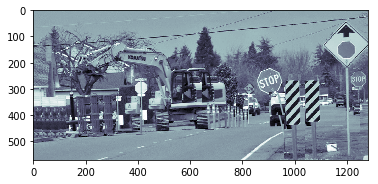

In [9]:
import glob           # file handling

custom_training_path = 'images/TEST_IMAGES/MixedCustom/AugmentBackground/'
(pedestrian_height, pedestrian_width) = (216, 82)

# Gather all test .png file names
custom_training_files = glob.glob (custom_training_path+'*.png')
n=0
for file in custom_training_files:
    image = cv2.imread(file, cv2.IMREAD_GRAYSCALE) 
    image_copy = image.copy()
    plt.imshow(image, cmap='bone')
    
    # Augment negative instance with 10 more randomly created from given background 
    file_name = 'CUSTOM_2_{:05d}_'.format(n+1)
    DataAugmentationNegativeInstances(image_copy, 150, pedestrian_width, pedestrian_height,'negative', file_name)
    n += 1

In [7]:
(150*3 + 300)/2700

0.2777777777777778